In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/EE-411-FOIL-Project/source

# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import librairies
import torchvision.transforms as transforms
import numpy as np
import os

In [3]:
# Import files
import constants
from models.resnet18k import make_resnet18k
from models.mcnn import make_cnn
from training_utils import*
from functions import*
from display_functions import*
from data_utils import*

# 1. Data preprocessing

## 1.1 Load data

### 1.1.1 Normal version

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

#### MNIST

In [ ]:
#Train Dataset
MNIST_train_dataset = torchvision.datasets.MNIST(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
MNIST_test_dataset = torchvision.datasets.MNIST(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform)

#### CIFAR 10

In [ ]:
#Train Dataset
CIFAR_10_train_dataset = torchvision.datasets.CIFAR10(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_10_test_dataset = torchvision.datasets.CIFAR10(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform)

#### CIFAR 100

In [ ]:
#Train Dataset
CIFAR_100_train_dataset = torchvision.datasets.CIFAR100(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_100_test_dataset = torchvision.datasets.CIFAR100(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform)

### 1.1.2. Augmented version

In [ ]:
transform_augmented_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_augmented_mnist = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

#### MNIST

In [ ]:
#Train Dataset
MNIST_train_dataset_aug = torchvision.datasets.MNIST(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform_augmented_mnist)

#Test Dataset
MNIST_test_dataset_aug = torchvision.datasets.MNIST(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform_augmented_mnist)

#### CIFAR 10

In [ ]:
#Train Dataset
CIFAR_10_train_dataset_aug = torchvision.datasets.CIFAR10(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform_augmented_cifar)

#Test Dataset
CIFAR_10_test_dataset_aug = torchvision.datasets.CIFAR10(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform_augmented_cifar)

#### CIFAR 100

In [ ]:
#Train Dataset
CIFAR_100_train_dataset_aug = torchvision.datasets.CIFAR100(
    root='../data/datasets',
    train=True,
    download=True,
    transform=transform_augmented_cifar)

#Test Dataset
CIFAR_100_test_dataset_aug = torchvision.datasets.CIFAR100(
    root='../data/datasets',
    train=False,
    download=True,
    transform=transform_augmented_cifar)

## 1.3 Vizualize the Dataset

### 1.3.1 Define class dictionaries

In [ ]:
#CIFAR-10
metadata_path = '../data/datasets/cifar-10-batches-py/batches.meta'
metadata = unpickle(metadata_path)
cifar10_dict = [label.decode('utf-8') for label in metadata[b'label_names']]

#CIFAR-100
metadata_path = '../data/datasets/cifar-100-python/meta'
metadata = unpickle(metadata_path)
cifar100_dict = [label.decode('utf-8') for label in metadata[b'fine_label_names']]

#### MNIST

In [ ]:
visualize_dataset((np.array(MNIST_train_dataset.data), np.array(MNIST_train_dataset.targets)), num_images=6)

#### CIFAR 10

In [ ]:
visualize_dataset((np.array(CIFAR_10_train_dataset.data), np.array(CIFAR_10_train_dataset.targets)), num_images=6,label_names=cifar10_dict)

#### CIFAR 100

In [ ]:
visualize_dataset((np.array(CIFAR_100_train_dataset.data), np.array(CIFAR_100_train_dataset.targets)), num_images=6,label_names=cifar100_dict)

# 2. Produce Figure 4

## 2.1 MNIST

In [12]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0,0.1,0.2]

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list, width_model_list, MNIST_train_dataset_aug, MNIST_test_dataset_aug)

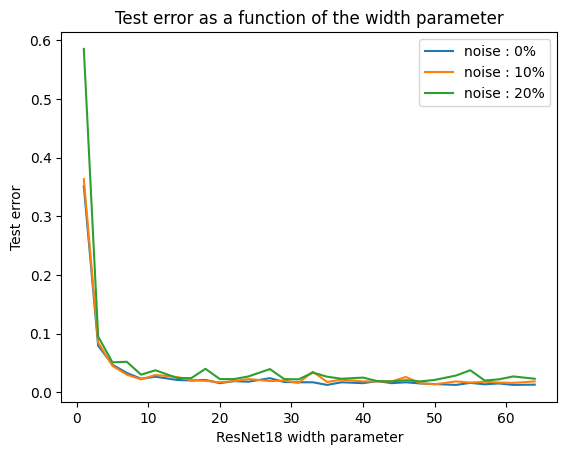

In [13]:
test_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'test_acc.pkl')
test_accuracies = open_pickle(test_accuracies_path)
test_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=test_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=False)

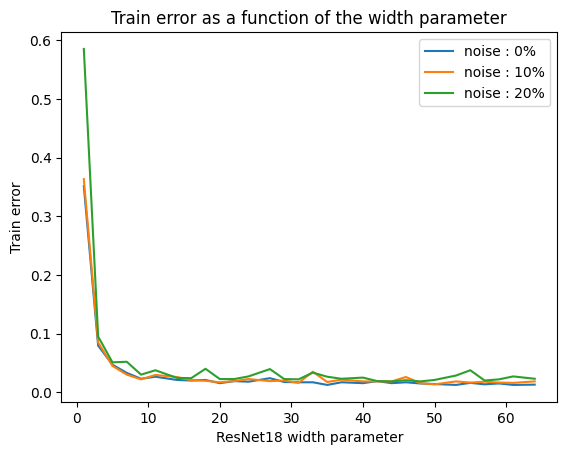

In [14]:
train_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'train_acc.pkl')
train_accuracies = open_pickle(test_accuracies_path)
train_errors = (100 - np.array(test_accuracies)) / 100
title = 'Train error rate as a function of the width of the network'
display_error(error_lists=train_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=True)

## Figure 6 : SGD vs Adam
5 Layer CNNs on CIFAR 10, no label noise, no data augmentation, using SGD for 500k gradient step, adam for 4K epochs

In [10]:
#Parameters to test
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0]

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list, width_model_list, MNIST_train_dataset, MNIST_test_dataset,optimizer = 'Adam')
train_losses_SGD, train_accuracies_SGD, test_losses_SGD, test_accuracies_SGD = train_models(noise_ratio_list, width_model_list, MNIST_train_dataset, MNIST_test_dataset,optimizer = 'SGD')

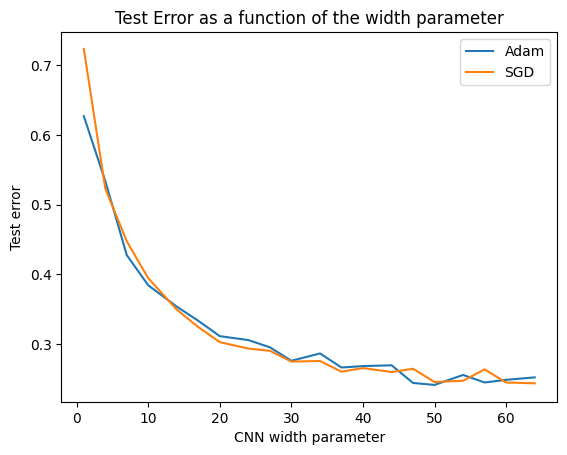

In [16]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
test_acc_sgd = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_Adam.pkl'))
test_acc_adam = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_SGD.pkl'))
test_error_sgd = (100 - np.array(test_acc_sgd)) / 100
test_error_adam = (100 - np.array(test_acc_adam)) / 100

display_optimizer_stats(test_error_adam,test_error_sgd,width_model_list)

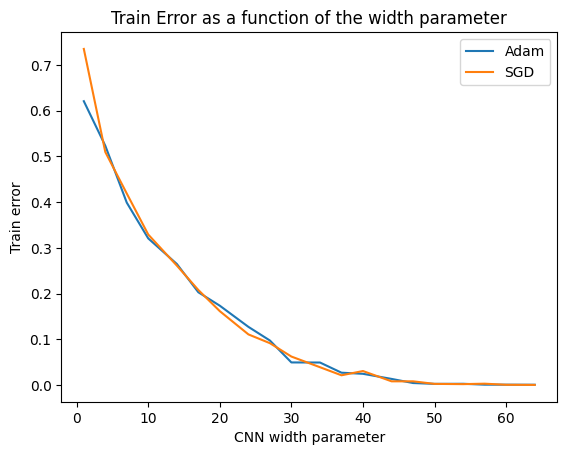

In [18]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
train_acc_sgd = open_pickle(os.path.join(constants.FIG6_FOLDER, 'train_accuracies_Adam.pkl'))
train_acc_adam = open_pickle(os.path.join(constants.FIG6_FOLDER, 'train_accuracies_SGD.pkl'))
train_error_sgd = (100 - np.array(train_acc_sgd)) / 100
train_error_adam = (100 - np.array(train_acc_adam)) / 100

display_optimizer_stats(train_error_adam,train_error_sgd,width_model_list,train=True)